In [202]:
import cmsisdsp as dsp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.io import loadmat
from dataclasses import dataclass

In [203]:
# numpy automatically upgrades to f64 if f64 is present in computation
# so we have to manually force f32 usage throughout
# Force everything to float32 for embedded compatibility
DTYPE = np.float32

@dataclass
class IMUData:
    """IMU measurements in float32"""
    gyro: np.ndarray  # rad/s [3x1]
    accel: np.ndarray  # m/s^2 [3x1]

    def __post_init__(self):
        self.gyro = self.gyro.astype(DTYPE)
        self.accel = self.accel.astype(DTYPE)

def quat_mult(q1, q2):
    """Quaternion multiplication"""
    # Ensure DTYPE inputs
    q1 = q1.astype(DTYPE)
    q2 = q2.astype(DTYPE)
    return dsp.arm_quaternion_product_single_f32(q1, q2)

def quat_conj(q):
    """Quaternion conjugate"""
    q = q.astype(DTYPE)
    return dsp.arm_quaternion_conjugate_f32(q)

def quat_exp(v):
    """Quaternion exponential"""
    v = v.astype(DTYPE)
    norm2_v = dsp.arm_dot_prod_f32(v, v)
    if norm2_v < 1e-8:
        return np.array([1.0, 0.0, 0.0, 0.0], dtype=DTYPE)
    else:
        norm_v = dsp.arm_sqrt_f32(norm2_v)[1]
        half_norm_v = 0.5 * norm_v
        exp_w = dsp.arm_cos_f32(half_norm_v)
        sin_half_norm_v = dsp.arm_sin_f32(half_norm_v)
        coeff = sin_half_norm_v / norm_v
        exp_vec = dsp.arm_scale_f32(v, coeff)
        return np.array([exp_w, exp_vec[0], exp_vec[1], exp_vec[2]], dtype=DTYPE)

def quaternion_to_dcm(q):
    """
    Convert quaternion to DCM (Body-to-Inertial/NED) - matches MATLAB CB2I
    Uses alternative formulation: CB2I = (s^2 - dot(v,v))*I + 2*(v*v') + 2*s*skew(v)
    CMSIS-DSP operations used where possible
    """
    q = q.astype(DTYPE)
    
    # Normalize quaternion using CMSIS-DSP
    q = dsp.arm_quaternion_normalize_f32(q)
    
    # Extract scalar and vector parts
    s = q[0]
    v = q[1:4]
    
    # Compute dot(v, v) using CMSIS-DSP
    v_dot_v = dsp.arm_dot_prod_f32(v, v)
    
    # Term 1: (s^2 - dot(v,v)) * eye(3)
    scalar_term = s**2 - v_dot_v
    term1 = scalar_term * np.eye(3, dtype=DTYPE)
    
    # Term 2: 2 * (v * v') - outer product
    term2 = np.zeros((3, 3), dtype=DTYPE)
    for i in range(3):
        for j in range(3):
            term2[i, j] = 2.0 * v[i] * v[j]
    term2 = term2.astype(DTYPE)
    # Term 3: 2 * s * skew(v)
    scale = DTYPE(2.0 * s)
    V = skew_symmetric(v).astype(DTYPE)
    term3 = dsp.arm_mat_scale_f32(V, scale)[1]
    
    # Build DCM: CB2I = term1 + term2 + term3
    DCM_b2n = dsp.arm_mat_add_f32(term1, term2)[1]
    DCM_b2n = dsp.arm_mat_add_f32(DCM_b2n, term3)[1]

    return DCM_b2n


def skew_symmetric(v):
    """Build skew-symmetric matrix - matches MATLAB skew()"""
    v = v.astype(DTYPE)

    skew = np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ], dtype=DTYPE)

    return skew


def compute_radii(lat_rad, a, e2):
    """Compute Earth radii and derivatives - matches MATLAB compute_radii()
    Returns:
        R_phi, R_lambda, dR_phi_dphi, dR_lambda_dphi (derivatives w.r.t latitude in radians)
    """
    sin_lat = np.sin(lat_rad)
    cos_lat = np.cos(lat_rad)

    sin_lat_sq = sin_lat * sin_lat
    f = 1.0 - e2 * sin_lat_sq
    sqrt_f = np.sqrt(f)

    # Radii of curvature
    R_phi = a * (1.0 - e2) / (sqrt_f**3)  # Eqn 7.69a (meridian)
    R_lambda = a / sqrt_f              # Eqn 7.69b (prime vertical)

    # Derivatives w.r.t phi (radians) - Eqns 7.75a, 7.75b
    dR_phi_dphi = 3.0 * a * (1.0 - e2) * e2 * sin_lat * cos_lat / sqrt_f**5
    dR_lambda_dphi = a * e2 * sin_lat * cos_lat / (sqrt_f**3)

    return DTYPE(R_phi), DTYPE(R_lambda), DTYPE(dR_phi_dphi), DTYPE(dR_lambda_dphi)


def compute_gravity(lat_rad, alt):
    """WGS84 gravity model and derivatives - matches MATLAB compute_g_dg()
    Returns:
        g, dg_dphi, dg_dh where phi is in radians and h is altitude in meters
    """
    sin_lat = np.sin(lat_rad)
    cos_lat = np.cos(lat_rad)
    sin_lat_sq = sin_lat * sin_lat
    sin_2lat = np.sin(2.0 * lat_rad)
    sin_2lat_sq = sin_2lat * sin_2lat
    sin_4lat = np.sin(4.0 * lat_rad)

    # Surface gravity
    g = 9.780327 * (1 + 5.3024e-3 * sin_lat_sq - 5.8e-6 * sin_2lat_sq) \
        - (3.0877e-6 - 4.4e-9 * sin_lat_sq) * alt + 7.2e-14 * alt ** 2

    # Derivative w.r.t latitude (radians)
    dg_dphi = 9.780327 * (5.3024e-3 * sin_2lat - 4.64e-5 * 0.25 * sin_4lat) \
              + 4.4e-9 * alt * sin_2lat

    # Derivative w.r.t altitude
    dg_dh = -3.0877e-6 + 4.4e-9 * sin_lat_sq + 1.44e-13 * alt

    return DTYPE(g), DTYPE(dg_dphi), DTYPE(dg_dh)


def compute_transport_rate(state, we, a, e2):
    """
    Compute wn (transport rate) - matches MATLAB compute_wn()
    """
    lat_rad = state[4] * np.pi / 180.0
    alt = state[6]
    vel = state[7:10]

    # Earth rotation component
    cos_lat = np.cos(lat_rad)
    sin_lat = np.sin(lat_rad)

    w_earth = np.array([
        we * cos_lat,
        0.0,
        -we * sin_lat
    ], dtype=DTYPE)

    # Motion over Earth surface
    R_phi, R_lambda, _, _ = compute_radii(lat_rad, a, e2)

    w_motion = np.array([
        vel[1] / (R_lambda + alt),  # East velocity effect
        -vel[0] / (R_phi + alt),     # North velocity effect
        -vel[1] * np.tan(lat_rad) / (R_lambda + alt)
    ], dtype=DTYPE)

    # Total transport rate using CMSIS add
    w_n = dsp.arm_add_f32(w_earth, w_motion)

    return w_n


def compute_w_hat(state, w_meas, DCM_b2n, we, a, e2):
    """
    Compute compensated angular rate - matches MATLAB compute_what()
    """
    q = state[0:4]
    gyro_bias = state[10:13]
    gyro_sf = state[16:19].astype(DTYPE)

    # Apply scale factor and bias correction
    ones = np.ones(3, dtype=DTYPE)
    sf_correction = dsp.arm_add_f32(ones, gyro_sf)

    # Element-wise operations
    w_meas = w_meas.astype(DTYPE)
    w_corrected = np.zeros(3, dtype=DTYPE)
    for i in range(3):
        w_corrected[i] = (w_meas[i] - gyro_bias[i]) / sf_correction[i]

    # Get transport rate
    w_n = compute_transport_rate(state, we, a, e2)

    # Transform to body frame
    DCM_n2b = dsp.arm_mat_trans_f32(DCM_b2n)[1]

    # Matrix-vector multiply using CMSIS
    w_n_body = dsp.arm_mat_vec_mult_f32(DCM_n2b, w_n)

    # Subtract transport rate in body frame
    w_hat = dsp.arm_sub_f32(w_corrected, w_n_body)

    return w_hat


def compute_ahat_n(state, a_meas, DCM_b2n):
    """
    Compute acceleration in NED frame - matches MATLAB compute_ahat()
    """
    q = state[0:4]
    accel_bias = state[13:16]
    accel_sf = state[19:22].astype(DTYPE)
    # Apply calibrations
    ones = np.ones(3, dtype=DTYPE)
    sf_correction = dsp.arm_add_f32(ones, accel_sf)
    # Compensate bias and scale factor
    a_meas = a_meas.astype(DTYPE)
    a_body = np.zeros(3, dtype=DTYPE)
    for i in range(3):
        a_body[i] = (a_meas[i] - accel_bias[i]) / sf_correction[i]
    # Transform to NED frame
    # Matrix-vector multiply using CMSIS
    a_ned = dsp.arm_mat_vec_mult_f32(DCM_b2n, a_body.astype(DTYPE))
    return a_ned


def compute_qdot(q, w_hat):
    """
    Quaternion derivative - matches MATLAB compute_qdot()
    Uses CMSIS-DSP quaternion product function
    
    qdot = 0.5 * q ⊗ w_quat
    where w_quat = [0, w_hat[0], w_hat[1], w_hat[2]]
    """
    q = q.astype(DTYPE)
    w_hat = w_hat.astype(DTYPE)

    # Build quaternion from angular rate
    # CMSIS-DSP quaternion format: [q0, q1, q2, q3] = [w, x, y, z]
    w_quat = np.array([0.0, w_hat[0], w_hat[1], w_hat[2]], dtype=DTYPE)

    # Use CMSIS-DSP quaternion product: q ⊗ w_quat
    q_dot = dsp.arm_quaternion_product_f32(q, w_quat)

    # Scale by 0.5 using CMSIS-DSP
    q_dot = dsp.arm_scale_f32(q_dot, DTYPE(0.5))

    return q_dot


def compute_lla_dot(state, a, e2):
    """
    Position derivatives - matches MATLAB compute_lla_dot()
    """
    phi_deg = state[4]
    alt = state[6]
    vn = state[7]
    ve = state[8]
    vd = state[9]

    deg2rad = DTYPE(np.pi / 180.0)
    rad2deg = DTYPE(180.0 / np.pi)
    phi_rad = deg2rad * phi_deg

    # Get radii
    R_phi, R_lambda, _, _ = compute_radii(phi_rad, a, e2)

    # Position derivatives (in radians/sec)
    lat_dot = vn / (R_phi + alt)
    lon_dot = ve / ((R_lambda + alt) * np.cos(phi_rad))
    alt_dot = -vd

    return np.array([rad2deg * lat_dot, rad2deg * lon_dot, alt_dot], dtype=DTYPE)


def compute_vdot(state, a_hat_n, we, a, e2):
    """
    Velocity derivatives - matches MATLAB compute_vdot()
    Updated to use compute_gravity returning derivatives.
    """
    phi_deg = state[4]
    alt = state[6]
    deg2rad = DTYPE(np.pi / 180.0)
    phi_rad = deg2rad * phi_deg

    vn = state[7]
    ve = state[8]
    vd = state[9]

    # Get gravity (ignore derivatives here)
    ghat, _, _ = compute_gravity(phi_rad, alt)

    # Get radii
    R_phi, R_lambda, _, _ = compute_radii(phi_rad, a, e2)

    # Trig terms
    sin_phi = np.sin(phi_rad)
    cos_phi = np.cos(phi_rad)

    # North velocity derivative
    vn_dot = -(ve/((R_lambda + alt)*cos_phi) + 2*we) * ve * sin_phi + \
             (vn * vd)/(R_phi + alt) + a_hat_n[0]

    # East velocity derivative
    ve_dot = (ve/((R_lambda + alt)*cos_phi) + 2*we) * vn * sin_phi + \
             (ve * vd)/(R_lambda + alt) + \
             2 * we * vd * cos_phi + a_hat_n[1]

    # Down velocity derivative (includes gravity)
    vd_dot = -ve**2/(R_lambda + alt) - vn**2/(R_phi + alt) - \
             2 * we * ve * cos_phi + ghat + a_hat_n[2]

    return np.array([vn_dot, ve_dot, vd_dot], dtype=DTYPE)

def compute_dpdot_dp(state, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi):
    """
    phi :Latitude
    h : Height
    vn, ve, vd :  Velocity
    we : Earth rotation 
    R_phi, R_lamb : Radii of curvature 
    dR_phi_dphi, dR_lamb_dphi : Derivatives of radii wrt latitude 
    dg_dphi, dg_dh :Derivatives of gravity

    """
    phi, h, vn, ve = state[4], state[6], state[7], state[8]
    deg2rad = DTYPE(np.pi / 180.0)
    rad2deg = DTYPE(180.0 / np.pi)
    phi_rad = deg2rad * phi
    cos_phi = dsp.arm_cos_f32(phi_rad)
    sin_phi = dsp.arm_sin_f32(phi_rad)
    sec_phi = 1.0 / cos_phi
    tan_phi = sin_phi / cos_phi

    # Denominators
    denom_Rphi = (R_phi + h)
    denom_Rlam = (R_lamb + h)

    

    # Eqn 7.80a terms
    m11 = -vn / (denom_Rphi ** 2) * dR_phi_dphi 
    m13 = rad2deg * -vn / (denom_Rphi ** 2) 

    m21 = -(ve * sec_phi) / (denom_Rlam ** 2) * dR_lamb_dphi \
          + (ve * sec_phi * tan_phi) / (denom_Rlam)
    m23 = rad2deg * -ve * sec_phi / (denom_Rlam ** 2)

    # Assemble final matrix
    dpdot_dp = np.array([
        [m11, 0.0, m13],
        [m21, 0.0, m23],
        [0.0,  0.0, 0.0]
    ], dtype=DTYPE)

    return dpdot_dp

def compute_dvdot_dp(state, we, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi, dg_dphi, dg_dh):
    """
    phi :Latitude
    h : Height
    vn, ve, vd :  Velocity
    we : Earth rotation 
    R_phi, R_lamb : Radii of curvature 
    dR_phi_dphi, dR_lamb_dphi : Derivatives of radii wrt latitude 
    dg_dphi, dg_dh :Derivatives of gravity

    """
    phi, h, vn, ve, vd = state[4], state[6], state[7], state[8], state[9]
    deg2rad = DTYPE(np.pi / 180.0)
    phi_rad = deg2rad * phi
    cos_phi = dsp.arm_cos_f32(phi_rad)
    sin_phi = dsp.arm_sin_f32(phi_rad)
    sec_phi = 1.0 / cos_phi
    tan_phi = sin_phi / cos_phi

    # Denominators
    denom_Rphi = (R_phi + h)
    denom_Rlam = (R_lamb + h)

    # Eqn 7.82a
    Y11 = -(ve**2 * sec_phi**2) / denom_Rlam \
          + (ve**2 * tan_phi) / (denom_Rlam**2) * dR_lamb_dphi \
          - 2 * we * ve * cos_phi \
          - (vn * vd) / (denom_Rphi**2) * dR_phi_dphi

    # Eqn 7.82b
    Y13 = (ve**2 * tan_phi) / (denom_Rlam**2) \
          - (vn * vd) / (denom_Rphi**2)

    # Eqn 7.82c
    Y21 = (ve * vn * sec_phi**2) / denom_Rlam \
          - (ve * vn * tan_phi) / (denom_Rlam**2) * dR_lamb_dphi \
          + 2 * we * vn * cos_phi \
          - (ve * vd) / (denom_Rlam**2) * dR_lamb_dphi \
          - 2 * we * vd * sin_phi

    # Eqn 7.82d
    Y23 = -ve * ((vn * tan_phi + vd) / (denom_Rlam**2))

    # Eqn 7.82e
    Y31 = (ve**2) / (denom_Rlam**2) * dR_lamb_dphi \
          + (vn**2) / (denom_Rphi**2) * dR_phi_dphi \
          + 2 * we * ve * sin_phi \
          + dg_dphi

    # Eqn 7.82f
    Y33 = (ve**2) / (denom_Rlam**2) \
          + (vn**2) / (denom_Rphi**2) \
          + dg_dh

    # Assemble final matrix
    dvdot_dp = np.array([
        [Y11, 0.0, Y13],
        [Y21, 0.0, Y23],
        [Y31, 0.0, Y33]
    ], dtype=DTYPE)

    return dvdot_dp


def compute_dpdot_dv(state, R_phi, R_lamb):
    phi, h = state[4], state[6]
    deg2rad = DTYPE(np.pi / 180.0)
    rad2deg = DTYPE(180.0 / np.pi)
    phi_rad = deg2rad * phi
    cos_phi = dsp.arm_cos_f32(phi_rad)
    sec_phi = 1.0 / cos_phi

    denom_Rphi = (R_phi + h)
    denom_Rlam = (R_lamb + h)

    m11 = rad2deg * 1.0 / denom_Rphi
    m22 = rad2deg *sec_phi / denom_Rlam
    m33 = -1.0

    dpdot_dv = np.diag([m11, m22, m33]).astype(DTYPE)
    return dpdot_dv

def compute_dvdot_dv(state, we, R_phi, R_lamb):
    """
    Parameters
    ----------
    phi : Latitude 
    h : Height 
    vn, ve, vd : Velocity 
    we :Earth rotation 
    R_phi, R_lamb :  Radii of curvature in meridian and prime vertical [m]

    """
    phi, h, vn, ve, vd = state[4], state[6], state[7], state[8], state[9]
    # CMSIS-DSP trigs
    deg2rad = DTYPE(np.pi / 180.0)
    phi_rad = deg2rad * phi
    cos_phi = dsp.arm_cos_f32(phi_rad)
    sin_phi = dsp.arm_sin_f32(phi_rad)
    tan_phi = sin_phi / cos_phi

    denom_Rphi = (R_phi + h)
    denom_Rlam = (R_lamb + h)

    # Eqn 7.83a
    Z11 = vd / denom_Rphi
    Z12 = (-2 * ve * tan_phi) / denom_Rlam + 2 * we * sin_phi
    Z13 = vn / denom_Rphi

    # Eqn 7.83b
    Z21 = (ve * tan_phi) / denom_Rlam + 2 * we * sin_phi
    Z22 = (vd + vn * tan_phi) / denom_Rlam
    Z23 = ve / denom_Rlam + 2 * we * cos_phi

    # Eqn 7.83c
    Z31 = (-2 * vn) / denom_Rphi
    Z32 = (-2 * ve) / denom_Rlam - 2 * we * cos_phi

    # Assemble the final 3x3 matrix
    dvdot_dv = np.array([
        [Z11, Z12, Z13],
        [Z21, Z22, Z23],
        [Z31, Z32, 0.0]
    ], dtype=DTYPE)

    return dvdot_dv


def compute_dwdp(state, we, R_phi, R_lamb,dR_phi_dphi, dR_lamb_dphi):
    """
    ----------
    phi : Latitude [rad]
    h : Altitude [m]
    vn, ve : North , east velocity 
    we : Earth rotation 
    R_phi, R_lamb : Radii of curvature
    dR_phi_dphi, dR_lamb_dphi : Derivative wrt latitude

    """
    phi, h, vn, ve = state[4], state[6], state[7], state[8]
    deg2rad = DTYPE(np.pi / 180.0)
    phi_rad = deg2rad * phi
    # === Trig functions (radians) ===

    cos_phi = dsp.arm_cos_f32(phi_rad)
    sin_phi = dsp.arm_sin_f32(phi_rad)
    tan_phi = sin_phi / cos_phi
    sec_phi = 1.0 / cos_phi

    # === Precompute radius sums ===
    Rl_h = R_lamb + h
    Rp_h = R_phi + h

    # === Eqn (7.74a) terms ===
    m11 = -we * sin_phi - ve / (Rl_h ** 2) * dR_lamb_dphi
    m13 = -ve / (Rl_h ** 2)
    m21 = vn / (Rp_h ** 2) * dR_phi_dphi
    m23 = vn / (Rp_h ** 2)
    m31 = (-we * cos_phi
           - (ve * sec_phi ** 2) / Rl_h
           + (ve * tan_phi) / (Rl_h ** 2) * dR_lamb_dphi)
    m33 = (ve * tan_phi) / (Rl_h ** 2)

    # === Assemble Jacobian ===
    dwdp = np.array([
        [m11, 0.0, m13],
        [m21, 0.0, m23],
        [m31, 0.0, m33]
    ], dtype=np.float32)

    return dwdp


def compute_dwdv(state, R_phi, R_lamb):
    """

    Parameters
    ----------
    phi : float
        Latitude [rad]
    h : float
        Altitude [m]
    R_phi, R_lamb : float
        Radii of curvature [m]

    """
    phi, h = state[4], state[6]
    deg2rad = DTYPE(np.pi / 180.0)
    phi_rad = deg2rad * phi
    sin_phi = dsp.arm_sin_f32(phi_rad)
    cos_phi = dsp.arm_cos_f32(phi_rad)
    tan_phi = sin_phi / cos_phi
    # === Eqn (7.74b) components ===
    m12 = 1.0 / (R_lamb + h)
    m21 = -1.0 / (R_phi + h)
    m32 = -tan_phi / (R_lamb + h)

    # === Assemble Jacobian ===
    dwdv = np.array([
        [0.0, m12, 0.0],
        [m21, 0.0, 0.0],
        [0.0, m32, 0.0]
    ], dtype=np.float32)

    return dwdv



def compute_F(state, a_meas, w_meas, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi, dg_dphi, dg_dh, DCM_b2n, we):
    q, bias_g, sf_g, bias_a, sf_a = state[0:4], state[10:13], state[13:16], state[16:19], state[19:22]
    # ==== Rotation matrices ====
    DCM_n2b = dsp.arm_mat_trans_f32(DCM_b2n)[1]

    # ==== F11 ====
    F11_vec = -1.0 / (1.0 + sf_g) * (w_meas - bias_g) #elementwise product of vectors
    F11 = skew_symmetric(F11_vec)  # 3x3 numpy array

    # ==== F12, F13 ====
    dwdp = compute_dwdp(state, we, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi)
    F12 = - dsp.arm_mat_mult_f32(DCM_n2b, dwdp)[1]

    dwdv = compute_dwdv(state, R_phi, R_lamb)
    F13 = - dsp.arm_mat_mult_f32(DCM_n2b, dwdv)[1]

    # ==== F14 ====
    F14 = np.diag(-1.0 / (1.0 + sf_g))

    # ==== F16 ====
    Omega = np.diag(w_meas)
    Bg = np.diag(bias_g)
    F16 = - dsp.arm_mat_sub_f32(Omega, Bg)[1]

    # ==== F22, F23 ====
    F22 = compute_dpdot_dp(state, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi)
    F23 = compute_dpdot_dv(state, R_phi, R_lamb)

    # ==== F31 ====
    ahat_n = compute_ahat_n(state, a_meas, DCM_b2n)
    ahat_b = dsp.arm_mat_vec_mult_f32(DCM_n2b, ahat_n)
    F31 = -dsp.arm_mat_mult_f32(DCM_b2n, skew_symmetric(ahat_b))[1]

    # ==== F32, F33 ====
    F32 = compute_dvdot_dp(state, we, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi, dg_dphi, dg_dh)
    F33 = compute_dvdot_dv(state, we, R_phi, R_lamb)

    # ==== F35 ====
    diag_sf_a = np.diag(1.0 / (1.0 + sf_a)).astype(DTYPE)
    F35 = -dsp.arm_mat_mult_f32(DCM_b2n, diag_sf_a)[1]

    # ==== F37 ====
    diag_diff = np.diag(a_meas - bias_a).astype(DTYPE)
    F37 = -dsp.arm_mat_mult_f32(DCM_b2n, diag_diff)[1]

    F = np.zeros((21, 21), dtype=DTYPE)

    # Attitude
    F[0:3, 0:3] = F11
    F[0:3, 3:6] = F12
    F[0:3, 6:9] = F13
    F[0:3, 9:12] = F14
    F[0:3, 15:18] = F16

    # Position
    F[3:6, 3:6] = F22
    F[3:6, 6:9] = F23

    # Velocity
    F[6:9, 0:3] = F31
    F[6:9, 3:6] = F32
    F[6:9, 6:9] = F33
    F[6:9, 12:15] = F35
    F[6:9, 18:21] = F37

    # The rest (bias/scale factor dynamics) remain zero
    return F

def compute_G(state, DCM_b2n):
    sf_g = state[16:19]
    sf_a = state[19:22]
    G11 = -np.diag(1.0 / (1.0 + sf_g))
    G33 = -dsp.arm_mat_mult_f32(DCM_b2n, np.diag(1.0 / (1.0 + sf_a)))[1]
    # Build G matrix
    G = np.zeros((21, 12), dtype=DTYPE)

    # Attitude
    G[0:3, 0:3] = G11
    # Velocity
    G[6:9, 6:9] = G33
    G[9:12, 3:6] = np.eye(3, dtype=DTYPE)  # Gyro bias
    G[15:18, 9:12] = np.eye(3, dtype=DTYPE)  # Accel bias
    return G

def compute_Pdot(state, P, Q, a_meas, w_meas, DCM_b2n, we, a, e2):
    #Get values from F feom state vector
    phi_rad = state[4] * np.pi / 180.0
    alt = state[6]
    R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi = compute_radii(phi_rad, a, e2)
    _, dg_dphi, dg_dh = compute_gravity(phi_rad, alt)
    F = compute_F(state, a_meas, w_meas, R_phi, R_lamb, dR_phi_dphi, dR_lamb_dphi, dg_dphi, dg_dh, DCM_b2n, we)
    G = compute_G(state, DCM_b2n)

    # CMSIS-DSP matrix operations
    # Pdot = F*P + P*F' + G*Q*G'
    FP = dsp.arm_mat_mult_f32(F, P)[1]
    Ft = dsp.arm_mat_trans_f32(F)[1]
    PFt = dsp.arm_mat_mult_f32(P, Ft)[1]
    GQ = dsp.arm_mat_mult_f32(G, Q)[1]
    Gt = dsp.arm_mat_trans_f32(G)[1]
    GQGt = dsp.arm_mat_mult_f32(GQ, Gt)[1]
    FP_plus_PFt = dsp.arm_mat_add_f32(FP, PFt)[1]
    Pdot = dsp.arm_mat_add_f32(FP_plus_PFt, GQGt)[1]
    return Pdot

def compute_Pqdot(state, Pq, Qq, w_meas, DCM_b2n):
    bg_minus = state[10:13]
    diff = dsp.arm_sub_f32( w_meas, bg_minus)
    I_omega =  dsp.arm_mat_vec_mult_f32(DCM_b2n, diff)
    Fq = np.zeros((6,6), dtype=DTYPE)
    Fq[0:3,3:6] = -np.eye(3, dtype=DTYPE)
    Fq[3:6,3:6] = skew_symmetric(I_omega)
    Gq = np.zeros((6,6), dtype=DTYPE)
    Gq[0:3,0:3] = DCM_b2n
    Gq[3:6,3:6] = -DCM_b2n
    # Pqdot = Fq*Pq + Pq*Fq' + Gq*Qq*Gq'
    FqPq = dsp.arm_mat_mult_f32(Fq, Pq)[1]
    Fqt = dsp.arm_mat_trans_f32(Fq)[1]
    PqFqt = dsp.arm_mat_mult_f32(Pq, Fqt)[1]
    GqQq = dsp.arm_mat_mult_f32(Gq, Qq)[1]
    Gqt = dsp.arm_mat_trans_f32(Gq)[1]
    GqQqGqt = dsp.arm_mat_mult_f32(GqQq, Gqt)[1]
    FqPq_plus_PqFqt = dsp.arm_mat_add_f32(FqPq, PqFqt)[1]
    Pqdot = dsp.arm_mat_add_f32(FqPq_plus_PqFqt, GqQqGqt)[1]
    return Pqdot


def integrate_euler(state, P, Pq, qdot, pdot, vdot, Pdot, Pqdot, dt):
    """
    Euler integration - matches MATLAB integrate()
    """
    dt = DTYPE(dt)
    # Build state derivative vector
    xdot = np.zeros(22, dtype=DTYPE)
    xdot[0:4] = qdot.astype(DTYPE)
    xdot[4:7] = pdot.astype(DTYPE)
    xdot[7:10] = vdot.astype(DTYPE)

    Pdot = Pdot.astype(DTYPE)
    # Biases and scale factors don't change (zeros)

    # Euler step using CMSIS scale and add
    xdot_scaled = dsp.arm_scale_f32(xdot, dt)
    state_new = dsp.arm_add_f32(state.astype(DTYPE), xdot_scaled)

    Pdot_scaled = dsp.arm_mat_scale_f32(Pdot, dt)[1]
    P_new = dsp.arm_mat_add_f32(P.astype(DTYPE), Pdot_scaled)[1]

    Pqdot_scaled = dsp.arm_mat_scale_f32(Pqdot, dt)[1]
    Pq_new = dsp.arm_mat_add_f32(Pq.astype(DTYPE), Pqdot_scaled)[1]

    # Normalize quaternion using CMSIS function
    q_normalized = dsp.arm_quaternion_normalize_f32(state_new[0:4])
    state_new[0:4] = q_normalized

    return state_new, P_new, Pq_new


def propagate_state(state_minus, P_minus, Pq_minus, Q, Qq, imu, we, dt, a, e2):
    """
    Main propagation function - matches MATLAB propagate()
    This is what runs at 100Hz on your STM32H573
    """
    q_minus = state_minus[0:4]
    DCM_b2n = quaternion_to_dcm(q_minus).astype(DTYPE)    # body -> NED

    # Compute compensated angular rate
    w_hat = compute_w_hat(state_minus, imu.gyro, DCM_b2n, we, a, e2)

    # Compute acceleration in NED
    a_hat_n = compute_ahat_n(state_minus, imu.accel, DCM_b2n)

    # Compute state derivatives
    qdot = compute_qdot(state_minus[0:4], w_hat)
    pdot = compute_lla_dot(state_minus, a, e2)
    vdot = compute_vdot(state_minus, a_hat_n, we, a, e2)
    Pdot = compute_Pdot(state_minus, P_minus, Q, imu.accel, imu.gyro, DCM_b2n, we, a, e2)
    Pqdot = compute_Pqdot(state_minus, Pq_minus, Qq, imu.gyro, DCM_b2n)

    # Integrate
    state_plus, P_plus, Pq_plus = integrate_euler(state_minus, P_minus, Pq_minus, qdot, pdot, vdot, Pdot, Pqdot, dt)

    return state_plus.astype(DTYPE), symmetrize_matrix(P_plus), Pq_plus

def symmetrize_matrix(M):
    """Ensure matrix is symmetric"""
    M_t = dsp.arm_mat_trans_f32(M)[1]
    sum = dsp.arm_mat_add_f32(M, M_t)[1]
    M_sym = dsp.arm_mat_scale_f32(sum, DTYPE(0.5))[1]
    # return M_sym.astype(DTYPE)
    return M

In [204]:
def update_mag(x_minus, P_minus, Pq_minus, Hq, Rq, R, mag_I, mag_meas):
    Hq_T = dsp.arm_mat_trans_f32(Hq)[1]
    H_P_q = dsp.arm_mat_mult_f32(Hq, Pq_minus)[1]
    H_P_Ht_q = dsp.arm_mat_mult_f32(H_P_q, Hq_T)[1]
    W_q = dsp.arm_mat_add_f32(H_P_Ht_q, Rq)[1]
    W_inv_q = dsp.arm_mat_inverse_f32(W_q)[1]
    P_Ht_q = dsp.arm_mat_mult_f32(Pq_minus, Hq_T)[1]
    Kq = dsp.arm_mat_mult_f32(P_Ht_q, W_inv_q)[1] # (6, 3)
    # Kq = np.linalg.solve(W_q.T, P_Ht_q.T).T.astype(DTYPE)

    H = np.hstack((skew_symmetric(mag_I), np.zeros((3, 18), dtype=DTYPE)))
    # K = P_minus*H'/(H*P_minus*H' + R);
    H_T = dsp.arm_mat_trans_f32(H)[1]
    H_P = dsp.arm_mat_mult_f32(H, P_minus)[1]
    H_P_Ht = dsp.arm_mat_mult_f32(H_P, H_T)[1]
    W = dsp.arm_mat_add_f32(H_P_Ht, R)[1]
    W_inv = dsp.arm_mat_inverse_f32(W)[1]
    P_Ht = dsp.arm_mat_mult_f32(P_minus, H_T)[1]
    K = dsp.arm_mat_mult_f32(P_Ht, W_inv)[1] # (21, 3)
    # K = np.linalg.solve(W.T, P_Ht.T).T.astype(DTYPE)

    q_minus = x_minus[0:4]
    DCM_b2n = quaternion_to_dcm(q_minus)
    dv = mag_I - dsp.arm_mat_vec_mult_f32(DCM_b2n, mag_meas.astype(DTYPE))
    err = Kq @ dv
    cq = err[0:3]
    cbg = err[3:6]
    dq = quat_exp(-cq/2)
    q_plus = dsp.arm_quaternion_product_f32(dq, q_minus)
    DCM_n2b = dsp.arm_mat_trans_f32(DCM_b2n)[1]
    cbg_body = dsp.arm_mat_vec_mult_f32(DCM_n2b, cbg)
    bg_plus = dsp.arm_sub_f32(x_minus[10:13], cbg_body)

    x_plus = x_minus.copy()
    x_plus[0:4] = q_plus
    x_plus[10:13] = bg_plus

    # Pq_plus = (eye(6) - Kq * Hq) * Pq_minus * (eye(6) - Kq * Hq)' + Kq * Rq * Kq';
    I_6 = np.eye(6, dtype=DTYPE)
    Kq_Hq = dsp.arm_mat_mult_f32(Kq, Hq)[1]
    I_minus_KqHq = dsp.arm_mat_sub_f32(I_6, Kq_Hq)[1]
    I_minus_KqHq_T = dsp.arm_mat_trans_f32(I_minus_KqHq)[1]
    Pq_T1 = dsp.arm_mat_mult_f32(I_minus_KqHq, Pq_minus)[1]
    Pq_T2 = dsp.arm_mat_mult_f32(Pq_T1, I_minus_KqHq_T)[1]
    Kq_T = dsp.arm_mat_trans_f32(Kq)[1]
    Kq_Rq = dsp.arm_mat_mult_f32(Kq, Rq)[1]
    Kq_Rq_KqT = dsp.arm_mat_mult_f32(Kq_Rq, Kq_T)[1]
    Pq_plus = dsp.arm_mat_add_f32(Pq_T2, Kq_Rq_KqT)[1]
    
    # P_plus = (eye(21,21) - K*H)*P_minus* (eye(21,21)-K * H)' + K*R*K';
    I_21 = np.eye(21, dtype=DTYPE)
    K_H = dsp.arm_mat_mult_f32(K, H)[1]
    I_minus_KH = dsp.arm_mat_sub_f32(I_21, K_H)[1]
    I_minus_KH_T = dsp.arm_mat_trans_f32(I_minus_KH)[1]
    K_T = dsp.arm_mat_trans_f32(K)[1]
    K_R = dsp.arm_mat_mult_f32(K, R)[1]
    K_R_KT = dsp.arm_mat_mult_f32(K_R, K_T)[1]
    P_T1 = dsp.arm_mat_mult_f32(I_minus_KH, P_minus)[1]
    P_T2 = dsp.arm_mat_mult_f32(P_T1, I_minus_KH_T)[1]
    P_plus = dsp.arm_mat_add_f32(P_T2, K_R_KT)[1]

    return x_plus, P_plus, Pq_plus

def update_GPS(x_minus, P_minus, Pq_minus, H, R, lla_meas):
    """
    Python conversion of update_GPS.m
    """
    # STEP 2: KALMAN GAIN
    trace_val = np.trace(P_minus[3:5, 3:5])
    if (trace_val + P_minus[5, 5]) > 1000:
        beta = DTYPE(0.25)
    else:
        beta = DTYPE(0.0)
    
    # W = (1+beta)*H*P_minus*H' + R;
    # We must index [1] to get the result array from the (status, result) tuple
    H_T = dsp.arm_mat_trans_f32(H)[1] 
    HP = dsp.arm_mat_mult_f32(H, P_minus)[1]
    W_inner = dsp.arm_mat_mult_f32(HP, H_T)[1] 
    W_scaled = dsp.arm_mat_scale_f32(W_inner, (DTYPE(1.0) + beta))[1]
    W = dsp.arm_mat_add_f32(W_scaled, R)[1]
    
    # K = P_minus*H'/ W;
    # Use the correct function name: arm_mat_inverse_f32
    W_inv = dsp.arm_mat_inverse_f32(W)[1] 
    T3 = dsp.arm_mat_mult_f32(P_minus, H_T)[1]
    K = dsp.arm_mat_mult_f32(T3, W_inv)[1]
    # K = np.linalg.solve(W.T, T3.T).T.astype(DTYPE)

    # 4) Delta_x = K @ (lla_meas - x_minus[4:7, :])
    z = lla_meas.astype(DTYPE)                       # (3,)
    x_pos = x_minus[4:7].astype(DTYPE)            # (3,)
    innov = dsp.arm_sub_f32(z, x_pos)                            # (3,)
    Delta_x = dsp.arm_mat_vec_mult_f32(K, innov)                 # (21,)

    # 5) State update (GPS doesn't update attitude)
    q_plus  = x_minus[0:4]                                    # (4,1)
    p_plus  = dsp.arm_add_f32(x_minus[4:7], Delta_x[3:6])
    v_plus  = dsp.arm_add_f32(x_minus[7:10], Delta_x[6:9])
    bg_plus = x_minus[10:13]                                  # (3,1)
    ba_plus = dsp.arm_add_f32(x_minus[13:16], Delta_x[12:15])
    kg_plus = dsp.arm_add_f32(x_minus[16:19], Delta_x[15:18])
    ka_plus = dsp.arm_add_f32(x_minus[19:22], Delta_x[18:21])

    x_plus = np.concatenate((q_plus, p_plus, v_plus, bg_plus, ba_plus, kg_plus, ka_plus)).astype(DTYPE)

    # P_plus = (eye(21,21) - K*H)*P_minus* (eye(21,21)-K * H)' + K*R*K';
    I_21 = np.eye(21, dtype=DTYPE)
    K_H = dsp.arm_mat_mult_f32(K, H)[1]
    I_minus_KH = dsp.arm_mat_sub_f32(I_21, K_H)[1]
    I_minus_KH_T = dsp.arm_mat_trans_f32(I_minus_KH)[1]
    K_T = dsp.arm_mat_trans_f32(K)[1]
    K_R = dsp.arm_mat_mult_f32(K, R)[1]
    K_R_KT = dsp.arm_mat_mult_f32(K_R, K_T)[1]
    P_T1 = dsp.arm_mat_mult_f32(I_minus_KH, P_minus)[1]
    P_T2 = dsp.arm_mat_mult_f32(P_T1, I_minus_KH_T)[1]
    P_plus = dsp.arm_mat_add_f32(P_T2, K_R_KT)[1]
    
    Pq_plus = Pq_minus

    return x_plus, P_plus, Pq_plus

def update_baro(x_minus, P_minus, Pq_minus, Hb_func, Rb, press_meas, hb):
    """
    Python conversion of update_baro.m
    Assumes Hb_func and hb are callable Python functions.
    """

    # Assumes CMSIS-DSP functions are available in scope:
    # arm_mat_mult_f32, arm_mat_trans_f32, arm_mat_inverse_f32, arm_add_f32, arm_sub_f32
    # and that inputs are shaped as column vectors/matrices.

    # STEP 2: KALMAN GAIN (K = P_minus H^T (H P_minus H^T + Rb)^-1)
    Hb = Hb_func(x_minus).astype(DTYPE, copy=False)

    # K = P_minus*Hb'/(Hb*P_minus*Hb' + Rb);
    Hb_T = dsp.arm_mat_trans_f32(Hb)[1]
    T1 = dsp.arm_mat_mult_f32(Hb, P_minus)[1]
    T2 = dsp.arm_mat_mult_f32(T1, Hb_T)[1]
    W = dsp.arm_mat_add_f32(T2, Rb)[1]
    W_inv = dsp.arm_mat_inverse_f32(W)[1]
    T3 = dsp.arm_mat_mult_f32(P_minus, Hb_T)[1]
    K = dsp.arm_mat_mult_f32(T3, W_inv)[1] # K is (21, 1)
    K = np.linalg.solve(W.T, T3.T).T.astype(DTYPE)

    # STEP 3: MEAS. UPDATE
    q_minus = x_minus[0:4]

    # Residual: y = z - h(x-)
    y = DTYPE(press_meas - hb(x_minus))                        # (m x 1)

    # Delta_x = K y
    Delta_x = dsp.arm_mat_scale_f32(K, y)[1]              # (n x 1)

    q_plus = q_minus
    # arm_add_f32 returns a numpy.ndarray directly (not a (status, result) tuple),
    # so do NOT index with [1]. Keep the returned arrays as column vectors.
    # arm_add_f32 returns 1D arrays; ensure column vectors for stacking
    p_plus = dsp.arm_add_f32(x_minus[4:7], Delta_x[3:6]).reshape(3, 1)
    v_plus = dsp.arm_add_f32(x_minus[7:10], Delta_x[6:9]).reshape(3, 1)
    bg_plus = x_minus[10:13].reshape(3, 1)
    ba_plus = dsp.arm_add_f32(x_minus[13:16], Delta_x[12:15]).reshape(3, 1)
    kg_plus = dsp.arm_add_f32(x_minus[16:19], Delta_x[15:18]).reshape(3, 1)
    ka_plus = dsp.arm_add_f32(x_minus[19:], Delta_x[18:]).reshape(3, 1)

    x_plus = np.concatenate((
        q_plus, p_plus, v_plus, bg_plus, ba_plus, kg_plus, ka_plus
    )).astype(DTYPE)

    # P_plus = (eye(21,21) - K*Hb)*P_minus* (eye(21,21)-K * Hb)' + K*Rb*K';
    I_21 = np.eye(21, dtype=DTYPE)
    K_H = dsp.arm_mat_mult_f32(K, Hb)[1]
    I_minus_KH = dsp.arm_mat_sub_f32(I_21, K_H)[1]
    I_minus_KH_T = dsp.arm_mat_trans_f32(I_minus_KH)[1]
    K_T = dsp.arm_mat_trans_f32(K)[1]
    K_Rb = dsp.arm_mat_mult_f32(K, Rb)[1]
    K_R_KT = dsp.arm_mat_mult_f32(K_Rb, K_T)[1]
    P_T1 = dsp.arm_mat_mult_f32(I_minus_KH, P_minus)[1]
    P_T2 = dsp.arm_mat_mult_f32(P_T1, I_minus_KH_T)[1]
    P_plus = dsp.arm_mat_add_f32(P_T2, K_R_KT)[1]
    
    Pq_plus = Pq_minus
    
    
    return x_plus, P_plus, Pq_plus

In [205]:
def nearest_PSD(A):
    """Project matrix A onto the nearest positive semi-definite matrix."""
    # Eigenvalue decomposition
    A_sym = symmetrize_matrix(A)
    eigvals, eigvecs = sp.linalg.eigh(A_sym)
    print(f"Info: Projected matrix onto nearest PSD. Minimum eigenvalue was {np.min(eigvals)}.")
    # print(f"eigvec with min eigval: {eigvecs[:, np.argmin(eigvals)]}")
    # Set negative eigenvalues to zero
    if np.min(eigvals) < 0:
        eigvals[eigvals < 0] = 1e-10
        # Reconstruct the matrix
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    else:
        return A

def EKF_update(x_prev, P_prev, Pq_prev, Q, Qq, H, Hq, hb_func, Hb_func, R, Rq, Rb, 
               a_meas, w_meas, lla_meas, mag_meas, press_meas, we, magI, dt, a, e2):
    """
    Main EKF update cycle - propagation + measurement updates
    
    Args:
        x_prev: Previous state [22x1]
        P_prev: Previous covariance [21x21]
        Pq_prev: Previous reduced covariance [6x6]
        Q: Process noise [12x12]
        Qq: Reduced process noise [6x6]
        H: GPS measurement matrix [3x21]
        Hq: Magnetometer measurement matrix [3x6]
        hb_func: Barometer measurement function
        Hb_func: Barometer Jacobian function
        R: GPS measurement noise [3x3]
        Rq: Magnetometer measurement noise [3x3]
        Rb: Barometer measurement noise [1x1]
        a_meas: Accelerometer measurement [3x1]
        w_meas: Gyroscope measurement [3x1]
        lla_meas: GPS LLA measurement [3x1] (NaN if unavailable)
        mag_meas: Magnetometer measurement [3x1] (NaN if unavailable)
        press_meas: Barometer pressure measurement [1x1] (NaN if unavailable)
        we: Earth rotation rate
        magI: Magnetic field in inertial frame [3x1]
        dt: Time step
        a: Earth semi-major axis
        e2: Earth eccentricity squared
        
    Returns:
        x_plus: Updated state [22x1]
        P_plus: Updated covariance [21x21]
        Pq_plus: Updated reduced covariance [6x6]
        deploy_drogue: Drogue deployment flag (0 or 1)
        deploy_chute: Main chute deployment flag (0 or 1)
    """
    
    # Create IMU data structure
    imu = IMUData(gyro=w_meas, accel=a_meas)
    
    # Propagate state and covariance
    x_minus, P_minus, Pq_minus = propagate_state(
        x_prev, P_prev, Pq_prev, Q, Qq, imu, we, dt, a, e2
    )
    
    # Initialize updated estimates with propagated values
    x_plus = x_minus.copy()
    P_plus = P_minus.copy()
    Pq_plus = Pq_minus.copy()
    
    # GPS update (if available)
    if not np.any(np.isnan(lla_meas)):
        x_plus, P_plus, Pq_plus = update_GPS(
            x_plus, P_plus, Pq_plus, H, R, lla_meas
        )
    
    # Magnetometer update (if available)
    if not np.any(np.isnan(mag_meas)):
        x_plus, P_plus, Pq_plus = update_mag(
            x_plus, P_plus, Pq_plus, Hq, Rq, R, magI, mag_meas
        )
    
    # # Barometer update (if available)
    # if not np.isnan(press_meas):
    #     x_plus, P_plus, Pq_plus = update_baro(
    #         x_plus, P_plus, Pq_plus, Hb_func, Rb, press_meas, hb_func
    #     )
    
    # Drogue deployment logic
    # velocity in NED: down is positive (index 9)
    # position in LLA: altitude is at index 6
    if x_plus[9] > 0 and x_prev[6] > x_plus[6]:
        deploy_drogue = True
    else:
        deploy_drogue = False
    
    # Main chute deployment (TODO: integrate terrain map)
    deploy_chute = 0
    
    # Ensure P_plus is positive semi-definite
    if np.any(np.diag(P_plus) < 0):
        print(f"Warning: Negative variance detected in P_plus diagonal. Minimum value: {np.min(np.diag(P_plus))}")
        P_plus = nearest_PSD(P_plus)
    return x_plus, P_plus, Pq_plus, deploy_drogue, deploy_chute



In [206]:
# Load data
print("Loading simulation data...")
mat_data = loadmat('sim_data_4_EKF_testing.mat')
sim_data = mat_data['sim_data']

acc = sim_data['acc'][0, 0].astype(DTYPE)
omega = sim_data['gyro'][0, 0].astype(DTYPE)
ned = sim_data['NED'][0, 0].astype(DTYPE)
GPS = sim_data['GPS'][0, 0].astype(DTYPE)
magB = sim_data['magB'][0, 0].astype(DTYPE)
magI = np.squeeze(sim_data['magI'][0, 0]).astype(DTYPE)
baro = np.squeeze(sim_data['baro'][0, 0]).astype(DTYPE)
t = np.squeeze(sim_data['time'][0, 0]).astype(DTYPE)
q_true = sim_data['q'][0, 0].astype(DTYPE)
velI_true = sim_data['velI'][0, 0].astype(DTYPE)
lla0 = np.squeeze(sim_data['LLA0'][0, 0]).astype(DTYPE)

N = int(np.floor(len(t) / 1))

# DEFINE CONSTANTS
we = DTYPE(7.29211e-5)  # Earth's sidereal rotation rate [rad/s]
a_earth = DTYPE(6378137.0)
b_earth = DTYPE(6356752.31425)
e2 = DTYPE(1.0 - (b_earth/a_earth)**2)

# DEFINE PARAMETERS
IMU_freq = 100  # sample rate
dt = DTYPE(1.0 / IMU_freq)
GPS_freq = 1
mag_freq = 10
baro_freq = 20

# Define H (GPS measurement matrix)
H = np.zeros((3, 21), dtype=DTYPE)
H[:, 3:6] = np.eye(3, dtype=DTYPE)  # Position measurement

# Barometer pressure model parameters
p0 = DTYPE(102715.47296217596)
a_baro = np.array([
    -0.004366921037228173,
    -5.0964993627948606e-5,
    1.6319216411827967e-9,
    -6.053135304413484e-13,
    6.911049045104908e-17,
    -4.516216131249696e-21,
    1.90623861182507e-25,
    -5.457995055935324e-30,
    1.0906415917824724e-34,
    -1.5456197431929747e-39,
    1.5609417634668778e-44,
    -1.1149608634620734e-49,
    5.500087730582754e-55,
    -1.7817554862391996e-60,
    3.409963106133886e-66,
    -2.9213421378235885e-72
], dtype=DTYPE)

# ...existing code...
def pressure_function(h, p0_unused, a):
    # p = 10^(a1 + a2*h + ... + a8*h^7)
    h2 = h * h
    h3 = h2 * h
    h4 = h3 * h
    h5 = h4 * h
    h6 = h5 * h
    h7 = h6 * h
    expo = (a[0]
            + a[1] * h
            + a[2] * h2
            + a[3] * h3
            + a[4] * h4
            + a[5] * h5
            + a[6] * h6
            + a[7] * h7)
    return DTYPE(DTYPE(10.0) ** DTYPE(expo))

def pressure_derivative(h, p0_unused, a):
    # dpdh = ln(10) * (a2 + 2 a3 h + ... + 7 a8 h^6) * 10^(a1 + a2 h + ... + a8 h^7)
    h2 = h * h
    h3 = h2 * h
    h4 = h3 * h
    h5 = h4 * h
    h6 = h5 * h
    sum_term = (a[1]
                + DTYPE(2.0) * a[2] * h
                + DTYPE(3.0) * a[3] * h2
                + DTYPE(4.0) * a[4] * h3
                + DTYPE(5.0) * a[5] * h4
                + DTYPE(6.0) * a[6] * h5
                + DTYPE(7.0) * a[7] * h6)
    expo = (a[0]
            + a[1] * h
            + a[2] * h2
            + a[3] * h3
            + a[4] * h4
            + a[5] * h5
            + a[6] * h6
            + a[7] * (h6 * h))
    p = DTYPE(DTYPE(10.0) ** DTYPE(expo))
    return DTYPE(np.log(DTYPE(10.0)) * DTYPE(sum_term) * p)
# ...existing code...
def hb_func(x):
    """Barometer measurement function"""
    return pressure_function(x[6], p0, a_baro)

def Hb_func(x):
    """Barometer Jacobian"""
    Hb = np.zeros((1, 21), dtype=DTYPE)
    Hb[0, 6] = pressure_derivative(x[6], p0, a_baro)
    return Hb

# Magnetometer measurement Jacobian
Hq = np.hstack([skew_symmetric(magI), np.zeros((3, 3), dtype=DTYPE)])

# Define R (measurement noise covariances)
R = np.diag([1.35e-5, 1.65e-5, 2.0]).astype(DTYPE)  # GPS noise
Rq = np.diag([3.2e-7, 4.1e-7, 3.2e-7]).astype(DTYPE)  # Magnetometer noise
Rb = np.array([[2.5e-3]], dtype=DTYPE)  # Barometer noise

# Define Q (process noise) - Equation 7.76b
nu_gv_mat = (np.deg2rad(12e-3) ** 1) * np.eye(3, dtype=DTYPE)
nu_gu_mat = (np.deg2rad(3/3600) ** 1) * np.eye(3, dtype=DTYPE)
nu_av_mat = ((200e-6 * 9.81) ** 1) * np.eye(3, dtype=DTYPE)
nu_au_mat = ((40e-6 * 9.8) ** 1) * np.eye(3, dtype=DTYPE)

Q = 10 * dt * np.block([
    [nu_gv_mat, np.zeros((3, 9), dtype=DTYPE)],
    [np.zeros((3, 3), dtype=DTYPE), nu_gu_mat, np.zeros((3, 6), dtype=DTYPE)],
    [np.zeros((3, 6), dtype=DTYPE), nu_av_mat, np.zeros((3, 3), dtype=DTYPE)],
    [np.zeros((3, 9), dtype=DTYPE), nu_au_mat]
]).astype(DTYPE)

Qq = 10 * dt * np.block([
    [nu_gv_mat, np.zeros((3, 3), dtype=DTYPE)],
    [np.zeros((3, 3), dtype=DTYPE), nu_gu_mat]
]).astype(DTYPE)

# DEFINE INITIAL CONDITIONS
q0 = np.array([0.707106781186548, 0.0, 0.707106781186547, 0.0], dtype=DTYPE)

# attitude, pos, vel, g bias, a bias, g sf, a sf
x0 = np.concatenate([
    q0,
    lla0,
    np.zeros(3, dtype=DTYPE),  # velocity
    np.zeros(3, dtype=DTYPE),  # gyro bias
    np.zeros(3, dtype=DTYPE),  # accel bias
    np.zeros(3, dtype=DTYPE),  # gyro scale factor
    np.zeros(3, dtype=DTYPE)   # accel scale factor
])

n = len(x0)

# Initial uncertainties
att_unc0 = DTYPE(1e-4)
pos_unc0 = DTYPE(1e-4)
vel_unc0 = DTYPE(1e-4)
gbias_unc0 = DTYPE(1e-4)
abias_unc0 = DTYPE(1e-4)
gsf_unc0 = DTYPE(1e-4)
asf_unc0 = DTYPE(1e-4)

# Create initial covariance matrix
P0 = np.diag(np.concatenate([
    att_unc0 * np.ones(3),
    pos_unc0 * np.ones(3),
    vel_unc0 * np.ones(3),
    gbias_unc0 * np.ones(3),
    abias_unc0 * np.ones(3),
    gsf_unc0 * np.ones(3),
    asf_unc0 * np.ones(3)
])).astype(DTYPE)

Pq0 = np.diag(np.concatenate([
    att_unc0 * np.ones(3),
    gbias_unc0 * np.ones(3)
])).astype(DTYPE)

# Set up initial conditions for the filter
x_plus_history = np.zeros((n, N + 1), dtype=DTYPE)
x_plus_history[:, 0] = x0
P_prev = P0.copy()
Pq_prev = Pq0.copy()
drogue_flag = True

print(f"\nRunning EKF for {N} samples...")
print(f"Time span: {t[0]:.2f}s to {t[N-1]:.2f}s")

# EKF LOOP
for i in range(N):
    # Get measurements
    a_meas = acc[:, i]
    w_meas = omega[:, i]
    lla_meas = GPS[:, i]
    mag_meas = magB[:, i]
    press_meas = baro[i]
    
    # EKF update
    x_plus, P_plus, Pq_plus, deploy_drogue, deploy_chute = EKF_update(
        x_plus_history[:, i], P_prev, Pq_prev, Q, Qq, H, Hq,
        hb_func, Hb_func, R, Rq, Rb, a_meas, w_meas, lla_meas,
        mag_meas, press_meas, we, magI, dt, a_earth, e2
    )
    
    x_plus_history[:, i + 1] = x_plus
    
    # Check drogue deployment
    if deploy_drogue and drogue_flag:
        print(f"Sample {i}")
        print(f"Deploying drogue at altitude {x_plus[6]:.1f}m, down speed {x_plus[9]:.2f}m/s")
        drogue_flag = False
    
    # Periodically ensure P is PSD

    if (i+1) % 10000 == 0:
        P_plus = nearest_PSD(P_plus)

    P_prev = P_plus.copy()
    Pq_prev = Pq_plus.copy()
    
    # Progress report
    if (i + 1) % (N // 10) == 0:
        print(f"Progress: {100 * (i + 1) / N:.0f}%")

print("\nEKF complete!")



Loading simulation data...

Running EKF for 116081 samples...
Time span: 0.00s to 1160.80s
Info: Projected matrix onto nearest PSD. Minimum eigenvalue was -0.9397435784339905.
Info: Projected matrix onto nearest PSD. Minimum eigenvalue was 2.3071677901498333e-07.
Progress: 10%
Sample 12230
Deploying drogue at altitude 57531.7m, down speed 0.36m/s
Info: Projected matrix onto nearest PSD. Minimum eigenvalue was 2.2646661363978637e-06.
Progress: 20%
Info: Projected matrix onto nearest PSD. Minimum eigenvalue was 8.290037385449978e-07.
Progress: 30%
Info: Projected matrix onto nearest PSD. Minimum eigenvalue was 3.2824658546815044e-07.
Progress: 40%
Info: Projected matrix onto nearest PSD. Minimum eigenvalue was 1.6142232084348507e-07.
Progress: 50%
Info: Projected matrix onto nearest PSD. Minimum eigenvalue was 1.164851397561506e-07.
Progress: 60%
Info: Projected matrix onto nearest PSD. Minimum eigenvalue was 5.7278214171674335e-08.
Info: Projected matrix onto nearest PSD. Minimum eigenv


Computing attitude errors...


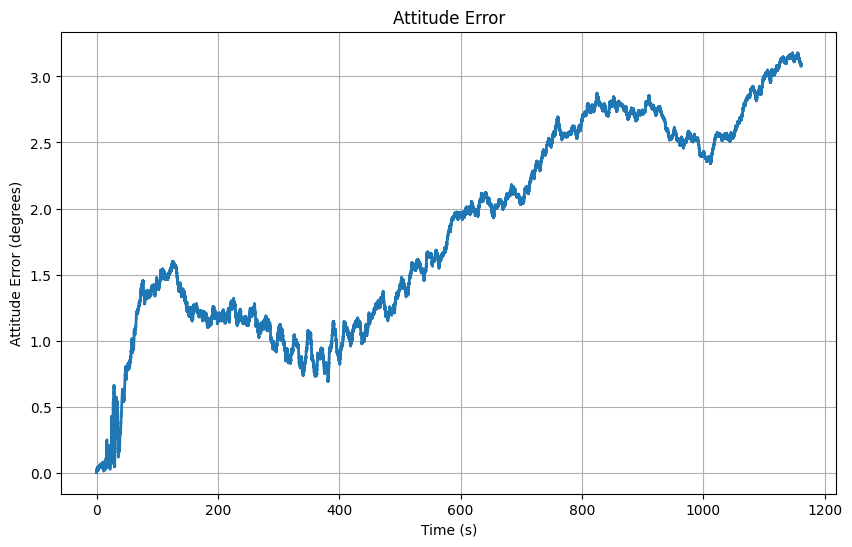

Computing position errors...


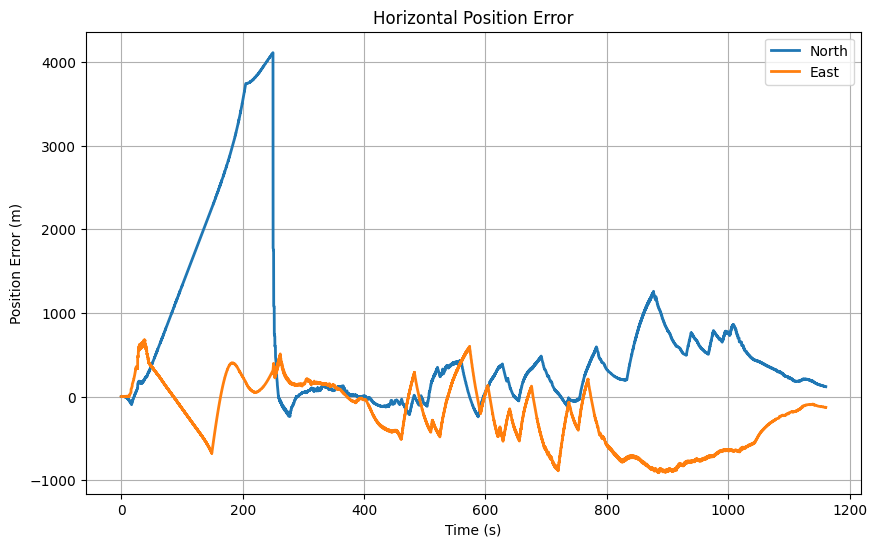

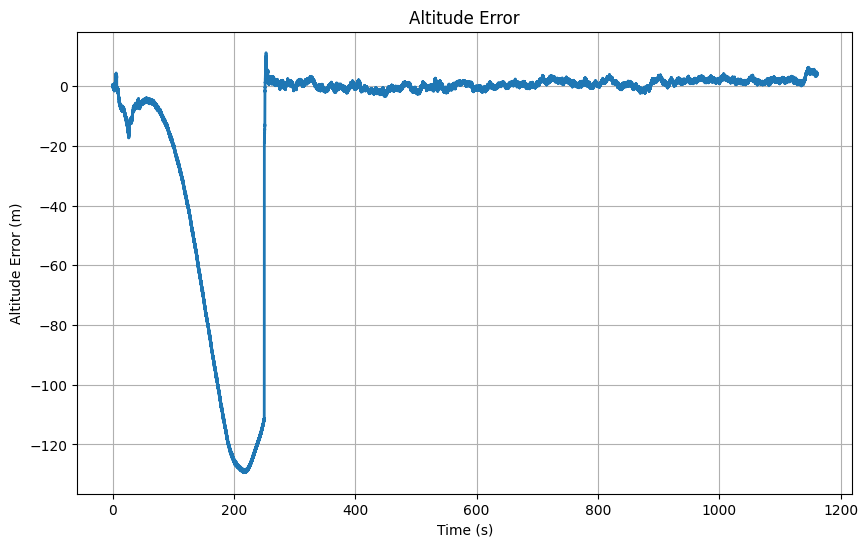

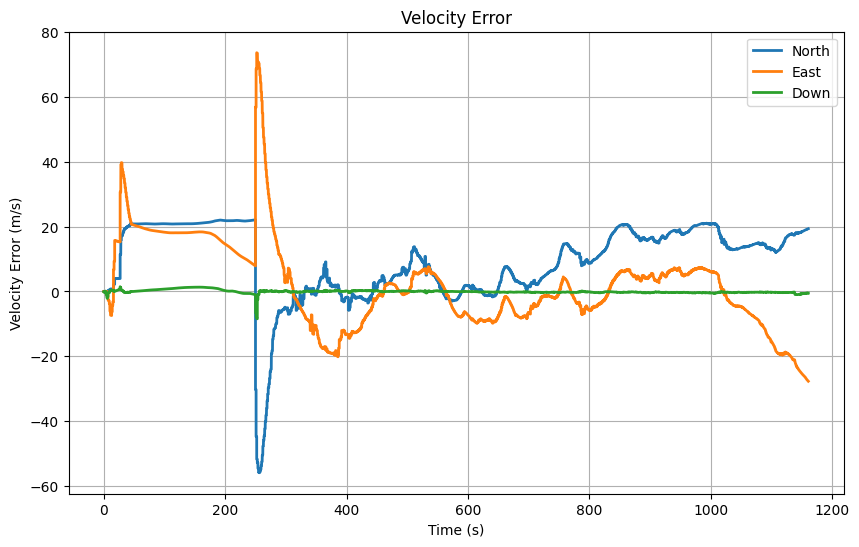


Validation complete!


In [207]:
# PLOTTING
def lla2ecef(lla):
    """
    Convert LLA (Latitude, Longitude, Altitude) to ECEF (Earth-Centered Earth-Fixed)
    
    Args:
        lla: [latitude (deg), longitude (deg), altitude (m)]
    
    Returns:
        ecef: [x, y, z] in meters
    
    Reference: "Optimal Estimation of Dynamic Systems" Appendix A, equations A.238-A.239
    Verified with Google Maps
    """
    lla = np.array(lla, dtype=DTYPE).flatten()
    
    # WGS84 parameters
    a = DTYPE(6378137.0)        # semi-major axis [m]
    b = DTYPE(6356752.3124)     # semi-minor axis [m]  
    e = DTYPE(0.08181919)       # eccentricity
    
    phi = lla[0]      # latitude in degrees
    lambda_ = lla[1]  # longitude in degrees
    h = lla[2]        # altitude in meters
    
    # Convert to radians for trig functions
    phi_rad = phi * np.pi / 180.0
    lambda_rad = lambda_ * np.pi / 180.0
    
    # Compute N (prime vertical radius of curvature) - equation A.238
    sin_phi = np.sin(phi_rad)
    N = a / np.sqrt(1.0 - (e * sin_phi)**2)
    
    # Compute ECEF coordinates - equation A.239
    cos_phi = np.cos(phi_rad)
    cos_lambda = np.cos(lambda_rad)
    sin_lambda = np.sin(lambda_rad)
    
    x = (N + h) * cos_phi * cos_lambda
    y = (N + h) * cos_phi * sin_lambda
    z = (N * (1.0 - e**2) + h) * sin_phi
    
    ecef = np.array([x, y, z], dtype=DTYPE)
    
    return ecef


def ecef2ned(ecef, lla0):
    """
    Convert ECEF to NED (North-East-Down) frame relative to reference point
    
    Args:
        ecef: [x, y, z] in ECEF frame [m]
        lla0: Reference LLA [lat (deg), lon (deg), alt (m)]
    
    Returns:
        ned: [north, east, down] in meters relative to lla0
    
    Reference: "Optimal Estimation of Dynamic Systems" Appendix A, equation A.242
    """
    ecef = np.array(ecef, dtype=DTYPE).flatten()
    lla0 = np.array(lla0, dtype=DTYPE).flatten()
    
    # Get ECEF of NED origin
    ecef0 = lla2ecef(lla0)
    
    # Reference point angles
    phi = lla0[0]      # latitude in degrees
    lambda_ = lla0[1]  # longitude in degrees
    # Convert to radians
    phi_rad = phi * np.pi / 180.0
    lambda_rad = lambda_ * np.pi / 180.0
    # Precompute trig functions
    s1 = np.sin(phi_rad)
    c1 = np.cos(phi_rad)
    s2 = np.sin(lambda_rad)
    c2 = np.cos(lambda_rad)
    # Build ECEF to NED rotation matrix (DCM) - equation A.242
    # This transforms from ECEF frame to NED frame centered at lla0
    Ae2n = np.array([
        [-s1*c2, -s1*s2,  c1],
        [-s2,     c2,     0.0],
        [-c1*c2, -c1*s2, -s1]
    ], dtype=DTYPE)
    # Compute relative ECEF position using CMSIS-DSP
    delta_ecef = dsp.arm_sub_f32(ecef, ecef0)
    # Transform to NED using matrix-vector multiply
    # Using CMSIS-DSP dot products for each row
    ned = dsp.arm_mat_vec_mult_f32(Ae2n, delta_ecef)
    return ned


def lla2ned(lla, lla0):
    """
    Convert LLA to NED frame relative to reference point
    
    Args:
        lla: [latitude (deg), longitude (deg), altitude (m)]
        lla0: Reference LLA [lat (deg), lon (deg), alt (m)]
    
    Returns:
        ned: [north, east, down] in meters relative to lla0
    
    This is the main function used in the EKF for position conversions.
    Combines lla2ecef and ecef2ned transformations.
    """
    # Convert LLA to ECEF
    ecef = lla2ecef(lla)
    # Convert ECEF to NED relative to reference
    ned = ecef2ned(ecef, lla0)
    return ned

# Attitude error
print("\nComputing attitude errors...")
att_error = np.zeros(N, dtype=DTYPE)
for k in range(N):
    q_hat = x_plus_history[0:4, k]
    q_t = q_true[:, k]
    # Right-invariant error quaternion
    q_err = quat_mult(q_t, quat_conj(q_hat))
    # Error angle in degrees
    att_error[k] = np.degrees(2 * np.arctan2(np.linalg.norm(q_err[1:4]), np.abs(q_err[0])))

plt.figure(figsize=(10, 6))
plt.plot(t[:N], att_error, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Attitude Error (degrees)')
plt.title('Attitude Error')
plt.grid(True)
plt.show()

# Position error (NED)
print("Computing position errors...")

ned_error = np.zeros((3, N), dtype=DTYPE)
for i in range(N):
    ned_est = lla2ned(x_plus_history[4:7, i], lla0)
    ned_error[:, i] = ned_est - ned[:, i]

# Horizontal position error
plt.figure(figsize=(10, 6))
plt.plot(t[:N], ned_error[0, :], linewidth=2, label='North')
plt.plot(t[:N], ned_error[1, :], linewidth=2, label='East')
plt.xlabel('Time (s)')
plt.ylabel('Position Error (m)')
plt.title('Horizontal Position Error')
plt.legend()
plt.grid(True)
plt.show()

# Altitude error
plt.figure(figsize=(10, 6))
plt.plot(t[:N], -ned_error[2, :], linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Altitude Error (m)')
plt.title('Altitude Error')
plt.grid(True)
plt.show()

# Velocity error
vel_error = x_plus_history[7:10, 1:N+1] - velI_true[:, :N]
plt.figure(figsize=(10, 6))
plt.plot(t[:N], vel_error[0, :], linewidth=2, label='North')
plt.plot(t[:N], vel_error[1, :], linewidth=2, label='East')
plt.plot(t[:N], vel_error[2, :], linewidth=2, label='Down')
plt.xlabel('Time (s)')
plt.ylabel('Velocity Error (m/s)')
plt.title('Velocity Error')
plt.legend()
plt.grid(True)
plt.show()

print("\nValidation complete!")